In [1]:
import sys
import os
import time

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import keras_cv as keras_cv
import tensorflow_datasets as tfds

#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [2]:

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [3]:
#Create Instances Of Utils Helper
seed = 5000
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4', 4: 'Species5', 5: 'Species6', 6: 'Species7',
          7: 'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../", seed, create_dirs=True)  #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper = ModelHelper("../../", labels)  #take in input local models folder and lables
model_helper.create_seed(tf, seed);

In [4]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

In [5]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train

In [6]:
# Y_train = np.argmax(Y_train, axis=1)

In [13]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def to_dict(image, label):
    return {"images": image, "labels": label}


def prepare_dataset(dataset):
    return (
        dataset.shuffle(10 * BATCH_SIZE)
        .map(to_dict)
        .batch(BATCH_SIZE)
    )



In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [15]:
train_dataset = prepare_dataset(train_dataset)

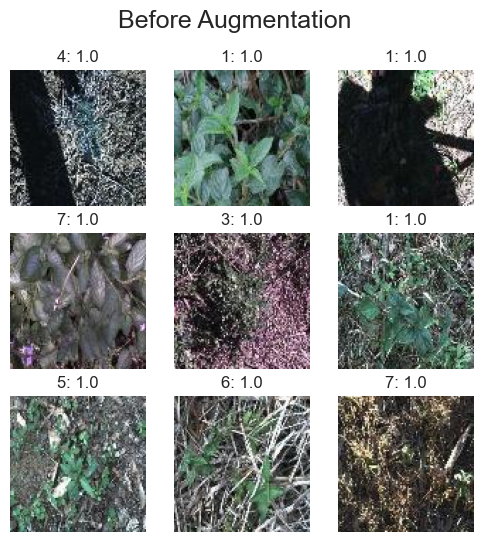

In [16]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples['images']
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0])
        plt.gca().set_title(', '.join(
            f"{i}: {'{:.1f}'.format(float(item))}" for i, item in enumerate(samples['labels'][0]) if float(item != 0)))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

In [17]:
# cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    # samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset_mix = train_dataset.map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

2022-11-22 00:42:51.145168: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


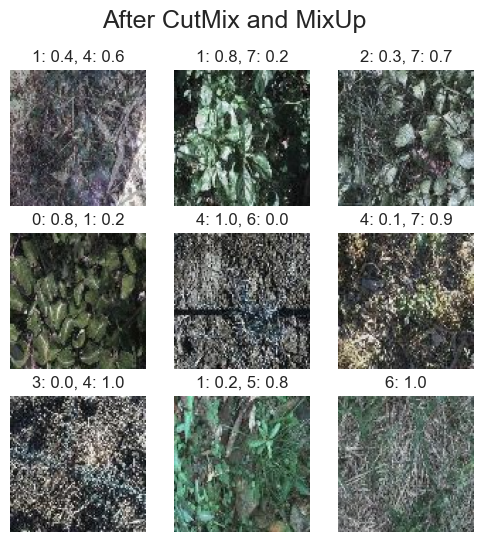

In [18]:
visualize_dataset(train_dataset_mix, title="After CutMix and MixUp")

2022-11-21 23:29:51.971463: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-21 23:29:51.972195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


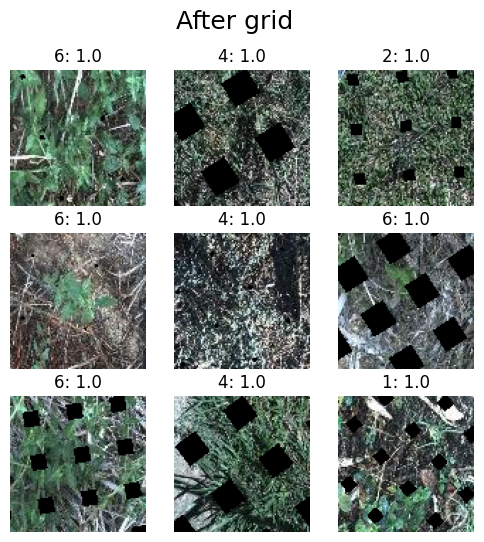

In [12]:
grid = keras_cv.layers.preprocessing.GridMask()

def apply_grid(samples):
    samples = grid(samples)
    return samples


train_dataset_grid = train_dataset.map(apply_grid)
visualize_dataset(train_dataset_grid, title="After grid")


([array([[[0.17323323, 0.22914502, 0.26291487],
          [0.19243056, 0.24834237, 0.28211218],
          [0.08738828, 0.1387792 , 0.17480946],
          ...,
          [0.28997436, 0.30680734, 0.35958567],
          [0.45548743, 0.47684127, 0.5273591 ],
          [0.61551654, 0.6368704 , 0.6873883 ]],
  
         [[0.23113179, 0.2870436 , 0.32081342],
          [0.15612659, 0.21203838, 0.24580824],
          [0.14376256, 0.19515347, 0.23118375],
          ...,
          [0.23806901, 0.25490198, 0.30768034],
          [0.45124018, 0.46807316, 0.5208515 ],
          [0.29634517, 0.31769902, 0.36821693]],
  
         [[0.19893819, 0.2503291 , 0.2818385 ],
          [0.15751404, 0.20890495, 0.24041432],
          [0.220344  , 0.27173492, 0.3032443 ],
          ...,
          [0.19599357, 0.2055827 , 0.25776175],
          [0.3801185 , 0.39422852, 0.4441471 ],
          [0.4200045 , 0.43411452, 0.4840331 ]],
  
         ...,
  
         [[0.10920461, 0.13526815, 0.18319997],
          [0.1

In [33]:
x =  []
y = []


np.array(x).shape

(2834, 96, 96, 3)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
list(train_dataset_X[0])

TypeError: 'MapDataset' object is not subscriptable

In [57]:
rand_idx = np.random.randint(len(X_train),size= int(0.5*len(X_train)))

array([  67, 1265, 1710, ..., 1381,  666,   50])